# Purity Network
Quantum Neural Network (QNN) that compute the purity of a given state

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *

from state_preparation import state_preparation_network, layer

In [2]:
%load_ext autoreload
%autoreload 2

## Constants

### Dataset

In [3]:
data_folder = "data"

n_qumodes = 2
size_system = n_qumodes * 2 # for purification
cutoff = 3
size_hilbert = cutoff**n_qumodes

ratio_train = 0.5

### State network

In [4]:
n_layers_sp = 20

### Purity Network

In [5]:
n_layers_pn = 20
batch_size_pn = 16

passive_std = 0.1
active_std = 0.001

## Loading the dataset

### Loading the files

In [6]:
rhos = np.load(os.path.join(data_folder, "rhos.npy"))
purities = np.load(os.path.join(data_folder, "purities.npy"))
list_params = np.load(os.path.join(data_folder, "list_params.npy"))

In [8]:
n_samples = len(rhos)
n_samples_train = int(ratio_train*n_samples)

In [10]:
samples_idx = np.random.choice(n_samples, size=n_samples, replace=False)
rhos = rhos[samples_idx]
purities = purities[samples_idx]
list_params = list_params[samples_idx]

### Dividing train and test

In [14]:
X_train = list_params[:n_samples_train]
X_test = list_params[n_samples_train:]

Y_train = purities[:n_samples_train]
Y_test = purities[n_samples_train:]

## Placeholders

#### State network
The parameters of the first network are the actual input of the network

In [15]:
# squeeze gate
sp_sq_r = tf.placeholder(tf.float32, [n_layers_sp, size_system])
sp_sq_phi = tf.placeholder(tf.float32, [n_layers_sp, size_system])

# displacement gate
sp_d_r = tf.placeholder(tf.float32, [n_layers_sp, size_system])
sp_d_phi = tf.placeholder(tf.float32, [n_layers_sp, size_system])

# interferometer
sp_inter_theta = tf.placeholder(tf.float32, [n_layers_sp*2, int(size_system*(size_system-1)/2)])
sp_inter_phi = tf.placeholder(tf.float32, [n_layers_sp*2, int(size_system*(size_system-1)/2)])
sp_inter_rphi = tf.placeholder(tf.float32, [n_layers_sp*2, size_system-1])

# kerr gate
sp_kappa = tf.placeholder(tf.float32, [n_layers_sp, size_system])

In [16]:
sp_params = [sp_sq_r, sp_sq_phi, sp_d_r, sp_d_phi, sp_inter_theta, sp_inter_phi, sp_inter_rphi, sp_kappa]

In [17]:
def get_feed_dict(params):
    return {sp_sq_r: np.array(list(params[0])),
            sp_sq_phi: np.array(list(params[1])),
            sp_d_r: np.array(list(params[2])),
            sp_d_phi: np.array(list(params[3])),
            sp_inter_theta: np.array(list(params[4])),
            sp_inter_phi: np.array(list(params[5])),
            sp_inter_rphi: np.array(list(params[6])),
            sp_kappa: np.array(list(params[7]))}

#### Purity network

In [18]:
purity_input = tf.placeholder(tf.float32)
lr_placeholder = tf.placeholder(tf.float32)

## Purity Network

### Parameters

In [19]:
# Initial parameters

# squeeze gate
pn_sq_r = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes], stddev=active_std))
pn_sq_phi = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes], stddev=passive_std))

# displacement gate
pn_d_r = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes], stddev=active_std))
pn_d_phi = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes], stddev=passive_std))

# interferometer
pn_inter_theta = tf.Variable(tf.random_normal(shape=[n_layers_pn*2, int(n_qumodes*(n_qumodes-1)/2)], stddev=passive_std))
pn_inter_phi = tf.Variable(tf.random_normal(shape=[n_layers_pn*2, int(n_qumodes*(n_qumodes-1)/2)], stddev=passive_std))
pn_inter_rphi = tf.Variable(tf.random_normal(shape=[n_layers_pn*2, n_qumodes-1], stddev=passive_std))

# kerr gate
pn_kappa = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes*2], stddev=active_std))

In [20]:
pn_params = [pn_sq_r, pn_sq_phi, pn_d_r, pn_d_phi, pn_inter_theta, pn_inter_phi, pn_inter_rphi, pn_kappa]

### Architecture

In [21]:
def purification_network(q, n_layers, params):
    # First layers with same size
    for i in range(n_layers_pn - (n_qumodes-2)): # same-size layers
        layer(i, q, params)
    
    # Progressive size reduction for the last layers
    for i in range(n_qumodes-2):
#         MeasureFock() | q[i]
        l = i+(n_layers_pn - (n_qumodes-2))
        layer(l, q[i+1:], params)
        
    # Measurement of the second-to-last qumode.
#     MeasureFock() | q[n_qumodes-2]

## Total Network

### Prepare the network

In [22]:
engine, q = sf.Engine(size_system)

In [23]:
with engine:
    state_preparation_network(q, n_layers_sp, sp_params)
    purification_network(q[:n_qumodes], n_layers_pn, pn_params)

In [24]:
state = engine.run('tf', cutoff_dim=cutoff, eval=False, modes=range(n_qumodes))

In [25]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [26]:
# Run engine
state = engine.run('tf', cutoff_dim=cutoff, eval=False, modes=[n_qumodes-1])

In [27]:
purity_output = tf.cast(state.quad_expectation(mode=0)[0], dtype=tf.float32)

### Cost and optimizer

In [28]:
def purity_mse(purity1, purity2):
    return tf.reduce_mean(tf.square(purity1 - purity2))

In [29]:
cost = purity_mse(purity_output, purity_input)

In [30]:
optimiser = tf.train.AdamOptimizer(learning_rate=lr_placeholder)
min_cost = optimiser.minimize(cost, var_list=pn_params)

In [31]:
sess.run(tf.variables_initializer(optimiser.variables()))

### Training

In [32]:
cost_train_list = []
cost_val_list = []
i = 0

In [68]:
nb_epochs = 30000
lr = 0.5e-4

for i in range(i, nb_epochs+i):
    cost_train = []
    samples_idx = np.random.choice(n_samples_train, size=n_samples_train, replace=False)
    for i_sample in range(n_samples_train):
        feed_dict = get_feed_dict(X_train[samples_idx[i_sample]])
        feed_dict[purity_input] = Y_train[samples_idx[i_sample]]
        feed_dict[lr_placeholder] = lr

        _, curr_cost = sess.run([min_cost, cost], feed_dict=feed_dict)
        cost_train.append(curr_cost)
    cost_train_list.append(np.mean(cost_train))
    
    clear_output(wait=True)
    print('Cost after step {:5d}: {: .7f}'.format(i, cost_train_list[-1]))
i = i+1

Cost after step 15646:  0.0208211


KeyboardInterrupt: 

### Visualization and result

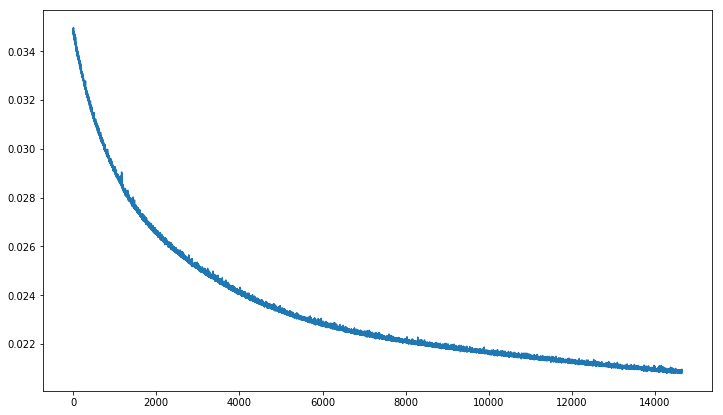

In [74]:
start = 1000
plt.rcParams['figure.figsize'] = (12,7)
plt.plot(cost_train_list[start:])

Text(0, 0.5, 'Prediction')

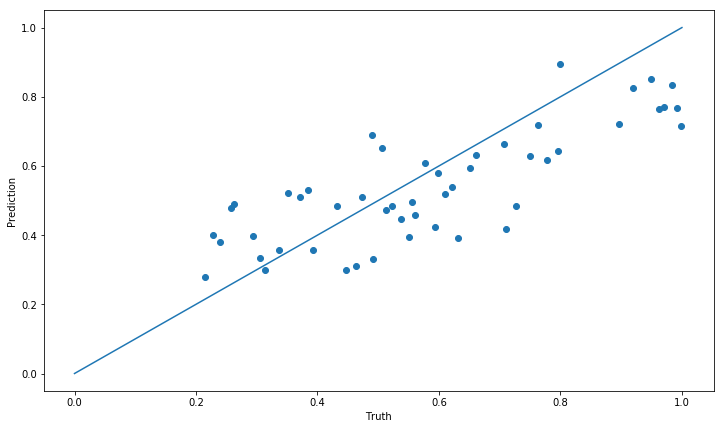

In [71]:
import pandas as pd

# df = pd.DataFrame(columns=["Truth", "Prediction"])
purity_pred = []
for j in range(n_samples_train):
    feed_dict = get_feed_dict(X_train[j])
    purity_pred.append(sess.run(purity_output, feed_dict=feed_dict))
#     df = df.append([{"Prediction": purity_pred, "Truth": Y_train[j]}])
# df.sort_values("Truth")
plt.scatter(Y_train, purity_pred)
plt.plot([0,1],[0,1])
plt.xlabel("Truth")
plt.ylabel("Prediction")